# Project 6: Training a Neural Network for Hand Written Image Classification

## Introduction

The Neural Network was inspired by the objective of modeling biological neural system. Now, it is used to achieve the result in Machine Learning area. We can say a Neural network perform the same way as neurons in the human brain, where each neuron takes input, perform some task, and pass the output to the next neuron [1].

We looked at the single layer NN (Neural Network), which was implemented by softmax function. In this report, we will implement two hidden layers, using a sigmoid function. As shown in the image, there is two hidden layer of 4 neurons and 1 output layer. And there is a connection across layer with each of the neurons.

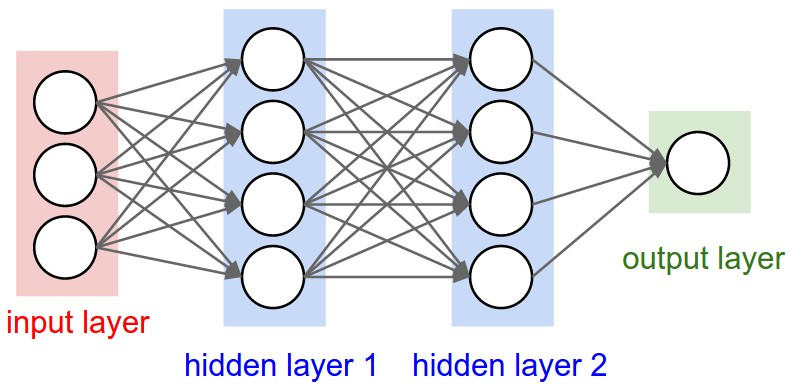

In [1]:
from IPython.display import Image
Image('NN.png')

This way we can help the computer to learn the images, here we are using the hand-written character. Later we will test that how our trained NN is behaving with our new set of data which it has not seen before. The data we are using is from MNIST data-set, where we have 60,000 images to train our data. And 10,000 images to test our data. In addition, we will train our data in mini batches, as we are optimizing our weights and we don't want it to stick in the local minima. This kind of problem can arise with such a large number of training data set.

## Methodology

### Scores and Weight
For this data-set, we have 10 classifiers. Which is $c=10$ different characters from 0 to 9. We can start with weight $W^T$, the dimension of this matrix is $m \times p$ where $m$ is the number of nodes (neurons) in the first hidden layer, and $p$ in the total number of pixel in our image. Also, $X$ is reshaped to $p \times n$, every image is flattened out and $n$ is the total number of images. We can compute our first score $S_1 = W^T \cdot x$. Then we can use the sigmoid function to find $R$. Sigmoid function can be define as, $$\alpha(z) = \frac{1}{1+ e^{-z}}$$

Now, we can introduce our second hidden layer. This new weight $V^T$ has dimension of $c \times m$. The second score can be computed by, $S_2 = V^T \cdot R$. Again apply sigmoid to finally get $T$. And our final loss can be written as, $$L = \sum_{i,j} (T_{j,i}-Y_{j,i})^{2}$$

Where, $Y$ is one hot form of true class images, for $i$ images in $j$ class is $1$ if it is the true class, otherwise $0$.

### Back Propagation

To find optimum weights, we used gradient descent technique. Although one need to compute gradient of our loss function with respect to our variable, i.e. our weights. To do so, we need to use chain rule to get final gradient. First,
$$ \frac{\partial L}{\partial T} = \frac{\partial \sum (T-Y)^{2}}{\partial T} = 2(T-Y)$$
Now, we can compute,
$$ \frac{\partial \alpha(z)}{\partial z} = \alpha(z)(1-\alpha(z))$$
therefore,
$$\frac{\partial L}{\partial S_2} = \frac{\partial L}{\partial T} \frac{\partial T}{\partial S_2}$$
Where we know $\frac{\partial L}{\partial T}$ from previous step, and $\frac{\partial T}{\partial S_2} = T(1-T)$. Similarly, we can find $\frac{\partial L}{\partial W^T}$, $\frac{\partial L}{\partial V^T}$.

And we can iterate with small step size ($\triangle x$) to descent toward minimum,
$$W^T = W^T - \triangle x \frac{\partial L}{\partial W^T}$$
$$V^T = V^T - \triangle x \frac{\partial L}{\partial V^T}$$

Interesting thing is to see the angle between the gradient of previous step and current step. To find these all thing let's define some functions,

In [3]:
%pylab inline
from PIL import Image
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [4]:
from mnist import MNIST
mndata = MNIST('data')  ############ Have data in 'data' folder or make necessary change ##########
image , lab = mndata.load_training()
image_test , lab_test = mndata.load_testing()

In [5]:
def alpha(x):
    expx = np.exp(-x)
    return 1/ (1 + expx)

def loss(WT,VT,X,Y):
    
    S1 = np.dot(WT,X)
    
    R = alpha(S1)
    
    S2 = np.dot(VT,R)
    
    T = alpha(S2)
    
    L = np.square(T-Y).sum()

    dLdT = np.ones_like(T)
    dLdT = 2*(T - Y)
    
    dLdS2 = dLdT*(T*(1-T))
    
    dLdVT = np.dot(dLdS2,R.T)
    
    dLdR = np.dot(VT.T,dLdS2)
    
    dLdS1 = dLdR*(R*(1-R))
    
    dLdWT = np.dot(dLdS1,X.T)
    
    ypred = argmax(T,axis=0)
    
    return L,dLdVT,dLdWT,ypred

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

We can check if our gradients are well defined, by applying finite difference. Which is approximated gradient, and should match up to machine precision digit. We will use random and fake images to check this.

In [6]:
n = 5 # number of images
p = 4 # number of pixels per image
c = 3  # number of classes
m = 6
y1 = np.random.choice( np.arange(c), n )  # fake true classes
yt = np.zeros((c,n))
yt[ y1, np.arange(n) ] = 1
X1 = np.random.rand(p,n) # fake images
WT1 = np.random.rand(m,p) # fake weights
VT1 = np.random.rand(c,m) # fake weights

delta = 1.0e-8
L0,dLdVT1,dLdWT1,ypred1 = loss(WT1,VT1,X1,yt)

WT2 = np.array(WT1)
WT2[2,3] = WT2[2,3] + delta  # perturb the [2,3] component of WT a little

L1, foo1, foo2, foo3 = loss(WT2,VT1,X1,yt)

approx = (L1-L0)/delta   # finite difference

print('exact ',dLdWT1[2,3],'(supposedly)')
print('approx',approx)

exact  0.05667457740981517 (supposedly)
approx 0.05667448732538105


In [7]:
delta = 1.0e-8
L0,dLdVT1,dLdWT1,ypred1 = loss(WT1,VT1,X1,yt)

VT2 = np.array(VT1)
VT2[2,3] = VT2[2,3] + delta

L1, foo1, foo2, foo3 = loss(WT1,VT2,X1,yt)

approx = (L1-L0)/delta   # finite difference

print('exact ',dLdVT1[2,3],'(supposedly)')
print('approx',approx)

exact  0.5127799275184943 (supposedly)
approx 0.5127798630155667


As we can see, the exact gradient and finite difference values are similar. So we can start training our data.

### Training

In [9]:
batch = np.arange(60000)
np.random.shuffle(batch)
c = 10
n = 60000
p = 28*28
m = 12

Y = np.zeros((c,n))
Y[ lab, np.arange(n) ] = 1

X1 = np.array(image).T
X = X1/(28*28)

WT = np.zeros((m,p))
WT = X.T[:m,:]  ### Initial weight as some initial images
VT = np.random.rand(c,m)
ytrue = np.array(lab)

ypred = np.empty(len(ytrue))

L = np.zeros(2500)
L1 = np.zeros(12)
correct_fraction = np.zeros(2500)
angle = np.zeros(2500)

Lfoo, dLdVT, dLdWT, ypred = loss(WT,VT,X,Y)

vect1 = dLdWT.reshape(m*p)
vect2 = dLdVT.reshape(c*m)
prevVect = np.append(vect1,vect2)

In [10]:
stepsize = 1e-3
for i in range(2500):
    for j in range(12):
        X_batch = X[ :,batch[j*5000:(j+1)*5000] ]
        Y_batch = Y[ :,batch[j*5000:(j+1)*5000] ]
        L1[j], dLdVT, dLdWT, ypred_batch = loss(WT,VT,X_batch,Y_batch)
        WT = WT -stepsize*dLdWT
        VT = VT -stepsize*dLdVT
        ypred[ batch[j*5000:(j+1)*5000] ] = ypred_batch
    L[i] = L1.sum()
    L1 = np.zeros(12)
    correct_fraction[i] = ((ypred==ytrue).sum()/len(ytrue))*100
    
    vect1 = dLdWT.reshape(m*p)
    vect2 = dLdVT.reshape(c*m)
    newVect = np.append(vect1,vect2)
    
    angle[i] = np.degrees(angle_between(prevVect,newVect))
    prevVect = newVect

95.595


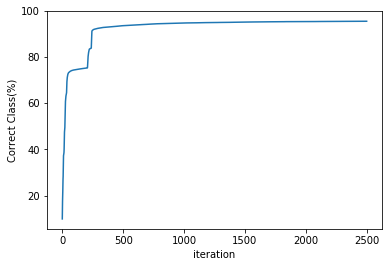

In [12]:
Loss = L
a = linspace(0,2500,2500, endpoint = False)
plt.plot(a,correct_fraction)
plt.xlabel('iteration')
plt.ylabel('Correct Class(%)')
print(correct_fraction[2499])

The NN was trained up to 95.59% of accuracy because of limiting computing power. One can see the correct class is improving as iteration passes.

Text(0,0.5,'Angle(degree)')

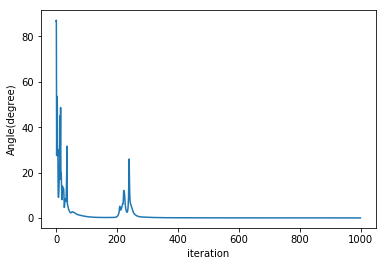

In [14]:
plt.plot(a[:1000],angle[:1000])
plt.xlabel('iteration')
plt.ylabel('Angle(degree)')

Here, angle between the gradient of weights for previous iteration versus current iteration is plotted. While improvement up to 250 iteration, we can see sudden changes in angle, i.e. the gradient descent is not straight down. Meaning function is more complex. Although it remain same when there is small changes in loss function and improvement after 400 iteration.

In [15]:
n = 10000
Ytest = np.zeros((c,n))
Ytest[ lab_test, np.arange(n) ] = 1
X1test = np.array(image_test).T
Xtest = X1test/(28*28)
ytrue_test = np.array(lab_test)

L_test = np.zeros(2500)
correct_fraction_test = np.zeros(2500)
angle_test = np.zeros(2500)

Lfoo, dLdVT, dLdWT, ypred_test = loss(WT,VT,Xtest,Ytest)

vect1 = dLdWT.reshape(m*p)
vect2 = dLdVT.reshape(c*m)
prevVect = np.append(vect1,vect2)

In [16]:
ypred_test = np.empty(len(ytrue_test))
stepsize = 1e-3
for i in range(2500):
    WT = WT -stepsize*dLdWT
    VT = VT -stepsize*dLdVT
    
    L_test[i], dLdVT, dLdWT, ypred_test = loss(WT,VT,Xtest,Ytest)
    
    vect1 = dLdWT.reshape(m*p)
    vect2 = dLdVT.reshape(c*m)
    newVect = np.append(vect1,vect2)
    
    angle_test[i] = np.degrees(angle_between(prevVect,newVect))
    prevVect = newVect
    
    correct_fraction_test[i] = ((ypred_test==ytrue_test).sum()/len(ytrue_test))*100

In [17]:
print(correct_fraction_test[0])

94.13


On first iteration, with our trained image we can hit up to 94.13% of accuracy.

Text(0,0.5,'Loss')

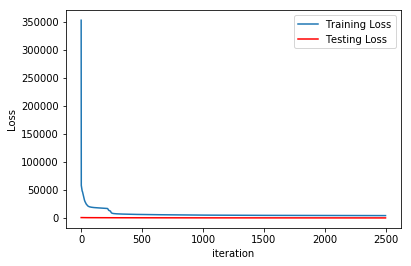

In [22]:
plt.plot( a , L ,label='Training Loss');
plt.plot( a , L_test , color='r' , label='Testing Loss')
plt.legend();
plt.xlabel('iteration')
plt.ylabel('Loss')

The loss function value is improving rapidly for training set, and then the rate is very low. And loss for testing set, from starting it is low. So it is plotted differently in next output.

Text(0,0.5,'Loss')

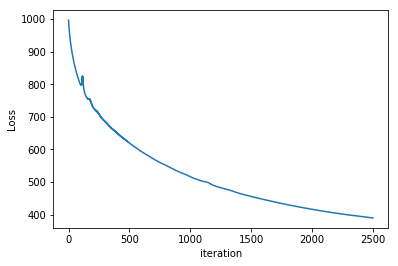

In [23]:
plt.plot( a , L_test)
plt.xlabel('iteration')
plt.ylabel('Loss')

97.48


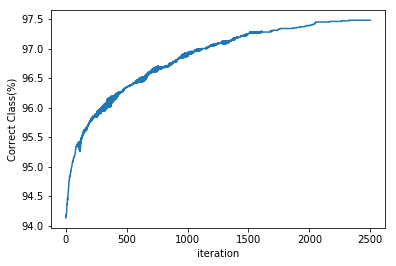

In [24]:
plt.plot(a,correct_fraction_test)
plt.xlabel('iteration')
plt.ylabel('Correct Class(%)')
print(correct_fraction_test[2499])

Above graph is the correct class prediction percentage. At final after 2500 iteration, we get 97.48% accuracy. We can visualize some image that was incorrect and weight below.

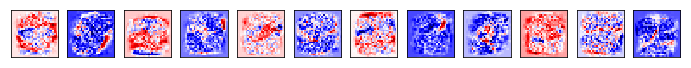

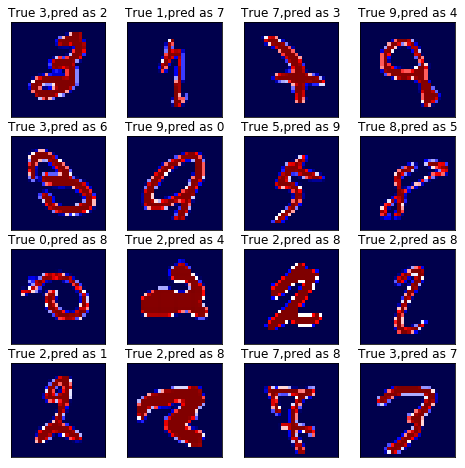

In [26]:
h = 28
w = 28 
plt.figure(figsize=(12,4))
for j in range(m):
    plt.subplot(1,m,j+1)
    plt.imshow( WT[j].reshape((h,w)), cmap='seismic')
    plt.xticks([])
    plt.yticks([])

incorrect_imagenumbers = np.where(ypred_test!=ytrue_test)[0]  # get indices of incorrect ones
nincorrect = len(incorrect_imagenumbers)
nsample = 16
samples = np.random.choice( incorrect_imagenumbers, min(nsample,nincorrect), replace=False)
plt.figure(figsize=(8,8))
for i,sample in enumerate(samples):
    plt.subplot(4,4,i+1)
    plt.imshow( X1test[:,sample].reshape((h,w)), cmap='seismic')
    plt.title( 'True '+str(ytrue_test[sample])+',pred as '+str(ypred_test[sample]) )
    plt.xticks([])
    plt.yticks([])

One can see that, the incorrect images are some what distorted and have mistakes in it. Weight $W^T$ is came out very unexplainable. Although it doesn't represent classes, but hidden nodes. We can see angle of gradients it took, while testing. It is clear that, function is not continuous and taking different angle every time to reach the optimum.

Text(0,0.5,'Angle(degree)')

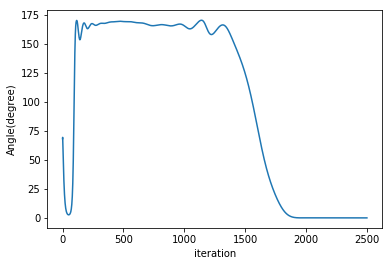

In [27]:
plt.plot(a,angle_test)
plt.xlabel('iteration')
plt.ylabel('Angle(degree)')

## Conclusion

We train the NN with mini batches of 5000 images and get the accuracy of 95.59%. This is clearly a better classifier, than other feature engineering like classifier. Testing on new set of 10,000 images gave us 94.13% correct value. Previously on single layer with 99.6% of training accuracy, we achieved 75% of accuracy on new set of images. One can clearly see the improvement by introduction of new hidden layer.
Although how much hidden layer, hidden layer neurons, step size and iteration require is problem dependent. One has to train and test the data set for right amount of values.

## References

    [1] http://cs231n.github.io/neural-networks-1/
    [2] https://www.youtube.com/watch?v=aircAruvnKk